## Preprocessing

In [38]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [39]:
df = pd.read_csv('./train.csv', parse_dates=['date'])
df_actual_test_set = pd.read_csv('./actualTestSet.csv', parse_dates=['date'])


#Handling 'date' column during importing the dataset
df['date'] = (df['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(milliseconds=1)
df_actual_test_set['date'] = (df_actual_test_set['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta(milliseconds=1)

#Checking number of columns and rows
df.shape

(38999, 12)

In [40]:
df_actual_test_set.shape
df_actual_test_set.head()


,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,1506470400000,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,1513036800000,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,1542499200000,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,1574035200000,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,1559433600000,night,heat,S6,D7,2600,NaN,7,NaN,B


In [41]:
# # Define the features (training_cols) and the target variable (target_col) - Here we are going to predict the cost values
# #So our target column is 'cost'

# #Splitting whole data into 'training_cols' and target_col.Where 'training_co'l contains all the columns excluding cost
# training_cols = df.drop('cost', axis=1)
# #target_col conatins cost column
# target_col = df['cost']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(training_cols, target_col, test_size=0.2, random_state=10)


# X_train.head()

### Cleaning

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

#Custom column dropper class
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold_percentage):
        self.threshold_percentage = threshold_percentage
        self.columns_to_drop = None

    def fit(self, X, y=None):
        print("% of null values per columns : ")
        print((X.isnull().sum()/X.shape[0])*100)
        self.columns_to_drop = X.columns[(X.isnull().sum()/X.shape[0])*100 > self.threshold_percentage]
        return self

    def transform(self, X):
        print(self.columns_to_drop)
        print("------------Dataset Info-------------")
        print(X.info())
        return X.drop(columns=self.columns_to_drop, axis=1)

#Class for dropping unwanted columns
#From the previous steps we found that , 'trip' colum indicating Id which is not usefull for modeling
#So we want to remove the column
class DropUnWantedColumns(BaseEstimator, TransformerMixin):
    def __init__(self,column_names):
        self.column_names = column_names

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        return X.drop(columns= self.column_names,axis=1)



class OneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.categories = None

    def fit(self, X, y=None):
        # Find unique categories in the specified column
        self.categories = X[self.column].unique()
        return self

    def transform(self, X, y=None):
        # Check if fit() has been called first
        if self.categories is None:
            raise ValueError("Call fit() before calling transform().")

        # Create one-hot encoded columns
        encoded_values = pd.get_dummies(X[self.column], columns=[self.column], prefix=self.column)

        # Merging df and one-hot encoder output
        X = pd.concat([X, pd.DataFrame(encoded_values.astype(bool).astype(int))], axis=1)

        # Drop the original column
        X.drop(columns=self.column, axis=1, inplace=True)

        return X


In [ ]:
from sklearn.pipeline import Pipeline

# Creating a new pipeline
pipeline = Pipeline([
    ('columnDropper', ColumnDropper(threshold_percentage=80)),  # Custom class
    ('dropUnWantedColumns', DropUnWantedColumns(column_names=['trip'])),  # Built-in Scaler
])

df = pipeline.predict(df)
df.info()

In [43]:
# # Setting threshold values for a benchmark.Based on this benchmark we decide which columns needs to keep or remove.
# #We decided 80% that is  more than 80% null values per columns will result in dropping that column
# # Creating an instance of the custom column dropper class
# threshold_percentage=80
# unwantedColumns = ['trip']
# column_dropper = ColumnDropper(threshold_percentage=threshold_percentage)
# # Appling the custom column dropper to the DataFrame
# # df = column_dropper.checking(df).transform(df)
# df = column_dropper.fit(df).transform(df)
# print("------------Dataset Info after droping columns-------------")
# df.info()
# dropUnWantedColumns = DropUnWantedColumns(column_names=unwantedColumns)
# df=dropUnWantedColumns.fit(df).transform(df)
# print("------------Dataset Info after droping unwanted columns-------------")
# df.info()

% of null values per columns : 
trip                    0.000000
date                    0.000000
dayPart                 0.000000
exWeatherTag           87.481730
originLocation          0.000000
destinationLocation     0.000000
distance                0.000000
type                   90.389497
weight                  0.000000
packageType            93.589579
carrier                 0.000000
cost                    0.000000
dtype: float64
Index(['exWeatherTag', 'type', 'packageType'], dtype='object')
------------Dataset Info-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  int64  
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  objec

In [44]:
#Here we checking the df to find any dupliactes rows are presented or not
print("Number of duplicated rows : ",df.duplicated().sum())
#We got value 64 for the above code.Which indicates there is 64 duplicated rows in the given df
#Here we dropping the duplicated rows
df.drop_duplicates(inplace=True)
print("Number of duplicated rows after drop_duplicates : ",df.duplicated().sum())


Number of duplicated rows :  67
Number of duplicated rows after drop_duplicates :  0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38932 entries, 0 to 38998
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 38932 non-null  int64  
 1   dayPart              38932 non-null  object 
 2   originLocation       38932 non-null  object 
 3   destinationLocation  38932 non-null  object 
 4   distance             38932 non-null  int64  
 5   weight               38932 non-null  int64  
 6   carrier              38932 non-null  object 
 7   cost                 38932 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.7+ MB


In [46]:
for col in df.columns:
    #To know about the unique values of each columns
    print(col)
    print("Number of unique values: ",df[col].nunique())
    print(df[col].unique())
    print("---------------------------------")


date
Number of unique values:  1074
[1504656000000 1508544000000 1500076800000 ... 1566691200000 1554768000000
 1570147200000]
---------------------------------
dayPart
Number of unique values:  2
['night' 'day']
---------------------------------
originLocation
Number of unique values:  9
['S4' 'S8' 'S9' 'S6' 'S7' 'S3' 'S5' 'S1' 'S2']
---------------------------------
destinationLocation
Number of unique values:  9
['D7' 'D1' 'D5' 'D4' 'D2' 'D9' 'D6' 'D3' 'D8']
---------------------------------
distance
Number of unique values:  17
[2200 1800 2800 3200 2000 1400 2400 1200 1600  600  800 2600 3400 3000
  400 1000 3600]
---------------------------------
weight
Number of unique values:  499
[ 50  12   1  43   3  17  21  16   8  19   2  20  32   5  27  38  33  26
  40  36  41  25  10  42  28  22  24  11  45   4  46  13  48   9 491  18
  47  34  31  15  35 240  39  37 432 313 415 311 442  44   6 239  23   7
 271  29 318 200  30  14 121 322  49 165 305 104 391 219 301 319 441 115
 251 461 20

From the above grpah and class balance ratio we understand there is a significant class imbalancing in carrier column.So wee need to rebalnce it

In [47]:
#Converting categorical values to numericals values
columnName= 'dayPart'
dayPartOneHotEncoder = OneHotEncoder(column = columnName)
df= dayPartOneHotEncoder.fit(df).transform(df)


columnName= 'originLocation'
originLocationOneHotEncoder = OneHotEncoder(column = columnName)
df= originLocationOneHotEncoder.fit(df).transform(df)

columnName= 'carrier'
carrierOneHotEncoder = OneHotEncoder(column = columnName)
df= carrierOneHotEncoder.fit(df).transform(df)

columnName= 'destinationLocation'
destinationLocationOneHotEncoder = OneHotEncoder(column = columnName)
df= destinationLocationOneHotEncoder.fit(df).transform(df)


#Df after applying onehot encoder to dayPart,originLocation and carrier column
df.head()

,date,distance,weight,cost,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
0,1504656000000,2200,50,68.413152,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,1508544000000,1800,12,36.450649,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1500076800000,2800,1,9.057939,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1508630400000,3200,50,57.320087,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1576022400000,2000,43,77.263777,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38932 entries, 0 to 38998
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    38932 non-null  int64  
 1   distance                38932 non-null  int64  
 2   weight                  38932 non-null  int64  
 3   cost                    38932 non-null  float64
 4   dayPart_day             38932 non-null  int32  
 5   dayPart_night           38932 non-null  int32  
 6   originLocation_S1       38932 non-null  int32  
 7   originLocation_S2       38932 non-null  int32  
 8   originLocation_S3       38932 non-null  int32  
 9   originLocation_S4       38932 non-null  int32  
 10  originLocation_S5       38932 non-null  int32  
 11  originLocation_S6       38932 non-null  int32  
 12  originLocation_S7       38932 non-null  int32  
 13  originLocation_S8       38932 non-null  int32  
 14  originLocation_S9       38932 non-null  int

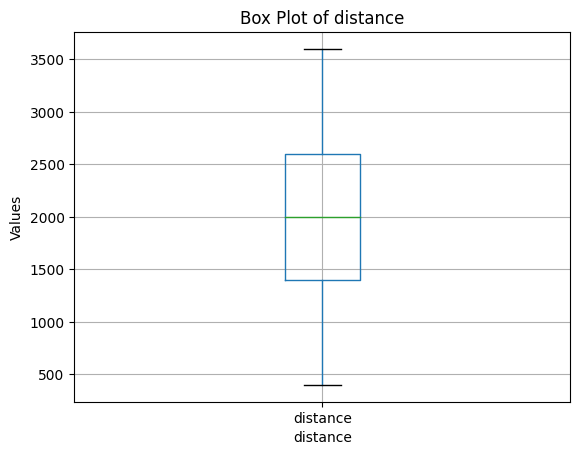

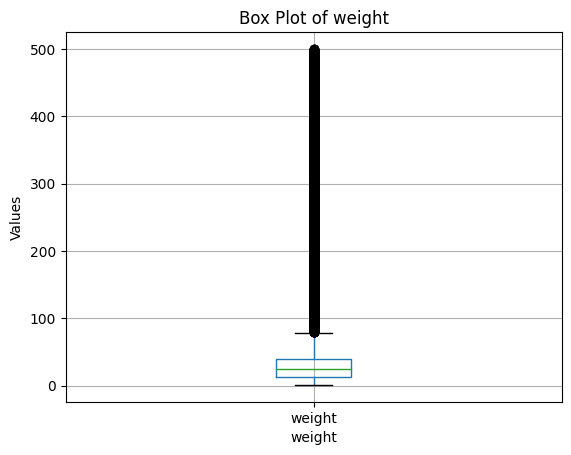

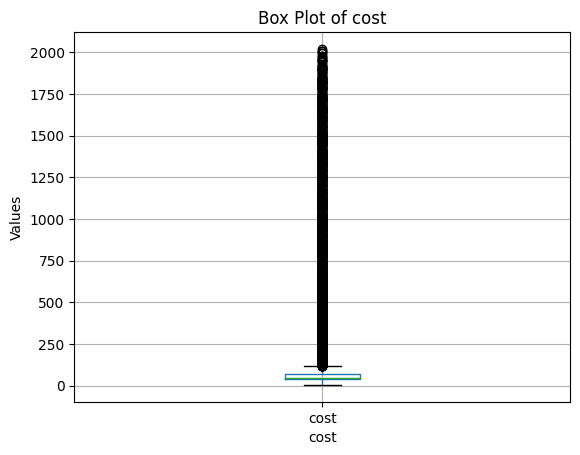

In [49]:
for column in ['distance','weight','cost']:
    plt.figure()  # Create a new figure for each box plot
    df.boxplot(column=[column])  # Create the box plot for the current column

    # Set plot title and labels
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Values')
    plt.show()


In [50]:
df.describe()

,date,distance,weight,cost,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
count,3.893200e+04,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,...,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000,38932.000000
mean,1.530266e+12,2003.960752,42.325028,81.029148,0.336150,0.663850,0.110629,0.107726,0.114405,0.110809,...,0.096270,0.109807,0.111194,0.112504,0.108574,0.111091,0.109755,0.110141,0.114610,0.112324
std,2.723518e+10,729.085611,75.532527,180.863857,0.472397,0.472397,0.313676,0.310038,0.318306,0.313899,...,0.294966,0.312653,0.314376,0.315989,0.311108,0.314249,0.312589,0.313069,0.318555,0.315769
min,1.483229e+12,400.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.506622e+12,1400.000000,13.000000,38.768742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.530144e+12,2000.000000,25.000000,46.478962,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.553731e+12,2600.000000,39.000000,70.239797,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.577664e+12,3600.000000,500.000000,2019.734797,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# # Function to remove outliers based on the IQR method
# def remove_outliers(df, column):
#     q1 = df[column].quantile(0.25)
#     q3 = df[column].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# # Remove outliers from the DataFrame
# df = remove_outliers(df, 'weight')
# df = remove_outliers(df, 'cost')



### Test

In [52]:
from sklearn.model_selection import train_test_split
X = df.drop('cost', axis=1)
y = df['cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Define the columns to be scaled (in this case, all columns)
columns_to_scale = ['date','distance','weight']

# Fit and transform the DataFrame to perform min-max scaling
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])







In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
features = X.columns.tolist()
target = 'cost'

train_set = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
train_set = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)


lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 87.67908155  95.80654985  92.13714669  74.19888354  96.56999986
 102.3549932   86.17746871  95.08955112  89.73281006  85.29304513]
Mean: 90.50395296996608


In [55]:
# from sklearn.svm import SVR

# # C_vals = [1,2,4,8,16,25,50,150,300,600,900]
# # gamma_vals = [0.0001,.001,.01,0.05, 0.10,0.15,0.30,0.60]
# C_vals = [1200]
# gamma_vals = [0.0001,.001,.01,0.05]

# param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
# grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
# grid_search_rbf.fit(X_train, np.ravel(y_train))

# print(grid_search_rbf.best_params_)
# print(np.sqrt(-grid_search_rbf.best_score_))

In [56]:
# from sklearn.metrics import mean_squared_error

# final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

# y_te_estimation = final_model.predict(X_test)

# final_mse = mean_squared_error(y_test, y_te_estimation)
# final_rmse = np.sqrt(final_mse)
# print(final_rmse)

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Create Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 7.4063834974916265
R-squared: 0.9997613187227286


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Create Gradient Boosting Regression model
model2 = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model2.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model2.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 15.078876336763791
R-squared: 0.9995140616921746


In [59]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# # Define the parameter grid for Grid Search
# param_grid = {
#     'n_estimators': [10,25,50, 100, 150,300],
#     'learning_rate': [0.005,0.001,0.01,0.05, 0.1, 0.2,.3],
#     'max_depth': [1,2,3, 4, 5,6,7]
# }

# # Create Gradient Boosting Regression model
# model = GradientBoostingRegressor(random_state=42)

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=3)
# grid_search.fit(X_train, y_train)

# # Get the best model with optimized hyperparameters
# best_model = grid_search.best_estimator_

# # Make predictions on the testing data using the best model
# y_pred = best_model.predict(X_test)

# # Calculate RMSE
# rmse = mean_squared_error(y_test, y_pred, squared=False)

# # Get the R-squared (accuracy) of the best model
# accuracy = r2_score(y_test, y_pred)

# print("Best Hyperparameters:", grid_search.best_params_)
# print("RMSE:", rmse)
# print("R-squared (Accuracy):", accuracy)


In [60]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.metrics import mean_squared_error, r2_score

# # Define the parameter grid for Grid Search
# param_grid_rf = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10]
# }

# param_grid_gb = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'max_depth': [3, 4, 5]
# }

# # Random Forest Regression
# rf_model = RandomForestRegressor(random_state=42)
# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=3)
# grid_search_rf.fit(X_train, y_train)
# best_rf_model = grid_search_rf.best_estimator_

# # Gradient Boosting Regression
# gb_model = GradientBoostingRegressor(random_state=42)
# grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, scoring='neg_mean_squared_error', cv=3)
# grid_search_gb.fit(X_train, y_train)
# best_gb_model = grid_search_gb.best_estimator_

# # Make predictions using the best models
# y_pred_rf = best_rf_model.predict(X_test)
# y_pred_gb = best_gb_model.predict(X_test)

# # Calculate RMSE and R-squared (accuracy) for the best models
# rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
# rf_r2 = r2_score(y_test, y_pred_rf)

# gb_rmse = mean_squared_error(y_test, y_pred_gb, squared=False)
# gb_r2 = r2_score(y_test, y_pred_gb)

# print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)
# print("Random Forest RMSE:", rf_rmse)
# print("Random Forest R-squared (Accuracy):", rf_r2)

# print("Best Gradient Boosting Hyperparameters:", grid_search_gb.best_params_)
# print("Gradient Boosting RMSE:", gb_rmse)
# print("Gradient Boosting R-squared (Accuracy):", gb_r2)


In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# Base Models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Hyperparameter tuning for base models
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='neg_mean_squared_error', cv=3)
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, scoring='neg_mean_squared_error', cv=3)

grid_search_rf.fit(X_train, y_train)
grid_search_gb.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
best_gb_model = grid_search_gb.best_estimator_

# Base model predictions
y_pred_rf = best_rf_model.predict(X_test)
y_pred_gb = best_gb_model.predict(X_test)

# Create meta-features
meta_features = pd.DataFrame({'RF_Prediction': y_pred_rf, 'GB_Prediction': y_pred_gb})

# Meta-regressor (Linear Regression)
meta_regressor = LinearRegression()
meta_regressor.fit(meta_features, y_test)

# Make final predictions using the meta-regressor
y_pred_meta = meta_regressor.predict(meta_features)

# Evaluate the meta-regressor
rmse_meta = mean_squared_error(y_test, y_pred_meta, squared=False)
r2_meta = r2_score(y_test, y_pred_meta)

print("Best Random Forest Hyperparameters:", grid_search_rf.best_params_)
print("Best Gradient Boosting Hyperparameters:", grid_search_gb.best_params_)
print("Meta-regressor RMSE:", rmse_meta)
print("Meta-regressor R-squared (Accuracy):", r2_meta)


Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Gradient Boosting Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Meta-regressor RMSE: 1.5123046228308286
Meta-regressor R-squared (Accuracy): 0.9999262960579121


In [62]:
#Flatten y_te for the graph
y_te = y_test.values.flatten()

In [63]:
# import matplotlib.pyplot as plt

# import plotly.graph_objects as go

# fig = go.Figure(data=go.Scattergl(
#     x=y_te, y=y_te_estimation,
#     mode='markers',
#     marker=dict(
#         color = y_te_estimation,
#         size = 5,
#         coloraxis="coloraxis")
# ))
# fig.update_yaxes(title_text="Predicted Values")
# fig.update_xaxes(title_text="Actual Values")
# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=800,
#     title_text="Predicted vs Actual Housing Prices",
# coloraxis=dict(colorscale='Viridis'))
# fig.update_traces(hovertemplate='Actual: %{x} <br> Predicted: %{y}') 
# fig.show()

In [64]:
y_ltr = np.log(y_train)
y_lte = np.log(y_test)

In [65]:

#Checking number of columns and rows
df_actual_test_set.shape

(802, 11)

In [66]:
df.head()

,date,distance,weight,cost,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
0,1504656000000,2200,50,68.413152,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
1,1508544000000,1800,12,36.450649,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1500076800000,2800,1,9.057939,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1508630400000,3200,50,57.320087,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1576022400000,2000,43,77.263777,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [67]:
df_actual_test_set.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,1506470400000,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,1513036800000,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,1542499200000,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,1574035200000,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,1559433600000,night,heat,S6,D7,2600,NaN,7,NaN,B


In [68]:
df_actual_test_set['destinationLocation'].unique()

array(['D8', 'D1', 'D6', 'D7', 'D5', 'D4', 'D2', 'D9', 'D3'], dtype=object)

In [69]:
test_copy=df_actual_test_set.copy()

# df_actual_test_set.drop(columns =[],axis=1,inplace=True)

# dropUnWantedColumns = DropUnWantedColumns(column_names=unwantedColumns)
# df=dropUnWantedColumns.fit(df).transform(df)
df_actual_test_set= dayPartOneHotEncoder.fit(df_actual_test_set).transform(df_actual_test_set)
df_actual_test_set= originLocationOneHotEncoder.fit(df_actual_test_set).transform(df_actual_test_set)
df_actual_test_set= carrierOneHotEncoder.fit(df_actual_test_set).transform(df_actual_test_set)
df_actual_test_set= destinationLocationOneHotEncoder.fit(df_actual_test_set).transform(df_actual_test_set)

df_actual_test_set.head()


,trip,date,exWeatherTag,distance,type,weight,packageType,dayPart_day,dayPart_night,originLocation_S1,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
0,t333282728025,1506470400000,NaN,2000,NaN,50,NaN,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,t35583500660,1513036800000,snow,600,NaN,22,NaN,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,t117664376784,1542499200000,NaN,1600,expedited,30,NaN,1,0,0,...,1,1,0,0,0,0,0,0,0,0
3,t261320757828,1574035200000,NaN,2200,NaN,32,NaN,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,t147086054909,1559433600000,heat,2600,NaN,7,NaN,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [70]:
df_actual_test_set.drop(columns =['trip','exWeatherTag','type','packageType'],axis=1,inplace=True)
df_actual_test_set.head()


,date,distance,weight,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,originLocation_S5,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
0,1506470400000,2000,50,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1513036800000,600,22,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1542499200000,1600,30,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,1574035200000,2200,32,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1559433600000,2600,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# Define the columns to be scaled (in this case, all columns)
columns_to_scale = ['date','distance','weight']

# Fit and transform the DataFrame to perform min-max scaling
df_actual_test_set[columns_to_scale] = scaler.transform(df_actual_test_set[columns_to_scale])
df_actual_test_set.head()


,date,distance,weight,dayPart_day,dayPart_night,originLocation_S1,originLocation_S2,originLocation_S3,originLocation_S4,originLocation_S5,...,carrier_D,destinationLocation_D1,destinationLocation_D2,destinationLocation_D3,destinationLocation_D4,destinationLocation_D5,destinationLocation_D6,destinationLocation_D7,destinationLocation_D8,destinationLocation_D9
0,0.246112,0.5000,0.098196,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.315645,0.0625,0.042084,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.627630,0.3750,0.058116,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0.961574,0.5625,0.062124,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.806953,0.6875,0.012024,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [72]:
out = meta_regressor.predict(df_actual_test_set)
out
result = pd.DataFrame({'trip': test_copy['trip'], 'cost': out})


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- carrier_A
- carrier_B
- carrier_C
- carrier_D
- date
- ...
Feature names seen at fit time, yet now missing:
- GB_Prediction
- RF_Prediction


In [ ]:
# np.savetxt("my_arr.csv", result, delimiter=',')
result.to_csv('results.csv', index=False)
